In [4]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib



In [13]:
# Cell 2: Load dataset
df = pd.read_csv("spams.csv", encoding='latin-1')[['v1','v2']]
df.columns = ['label', 'message']

# Replace ham/spam with more clear labels
df['label'] = df['label'].map({'ham': 'Not Spam', 'spam': 'Spam'})
df.head()




,label,message
0,Not Spam,"Go until jurong point, crazy.. Available only ..."
1,Not Spam,Ok lar... Joking wif u oni...
2,Spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,Not Spam,U dun say so early hor... U c already then say...
4,Not Spam,"Nah I don't think he goes to usf, he lives aro..."


In [14]:
# Cell 3: Clean text (remove punctuation, lowercase, etc.)
def clean_text(text):
    text = text.lower()  
    text = re.sub(r'\d+', '', text)  
    text = text.translate(str.maketrans('', '', string.punctuation))  
    text = text.strip()  
    return text

df['cleaned_message'] = df['message'].apply(clean_text)
df.head()


,label,message,cleaned_message
0,Not Spam,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Not Spam,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,Not Spam,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,Not Spam,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


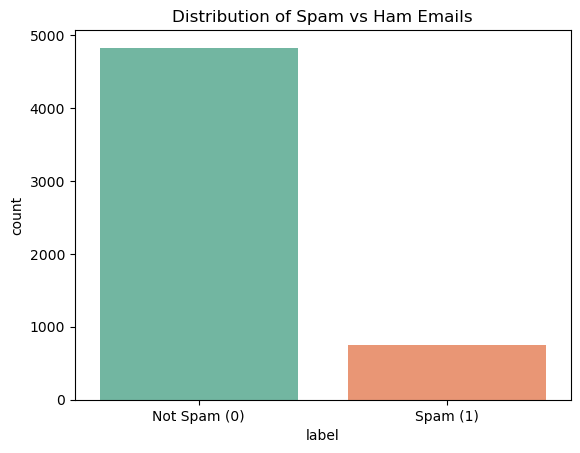

In [16]:
# Cell 4: Distribution of spam vs ham
sns.countplot(x='label', data=df, hue='label', palette="Set2", legend=False)
plt.xticks([0,1], ['Not Spam (0)', 'Spam (1)'])
plt.title("Distribution of Spam vs Ham Emails")
plt.show()



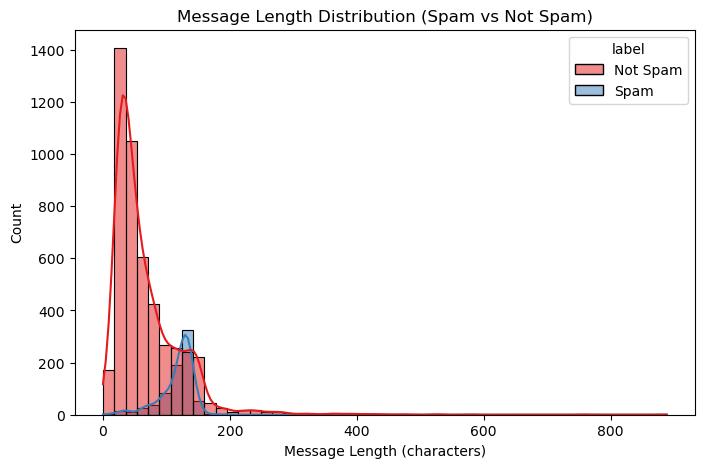

In [18]:
# Cell 5: Distribution of message lengths
df['msg_length'] = df['cleaned_message'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(data=df, x='msg_length', hue='label', bins=50, kde=True, palette="Set1")
plt.title("Message Length Distribution (Spam vs Not Spam)")
plt.xlabel("Message Length (characters)")
plt.ylabel("Count")
plt.show()


In [27]:
# Cell 6: Split data into train/test sets and vectorize using TF-IDF

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_message'], df['label'], test_size=0.2, random_state=42
)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Print some useful info
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Shape of TF-IDF training data:", X_train_tfidf.shape)
print("Shape of TF-IDF test data:", X_test_tfidf.shape)


Training samples: 4457
Testing samples: 1115
Shape of TF-IDF training data: (4457, 5000)
Shape of TF-IDF test data: (1115, 5000)


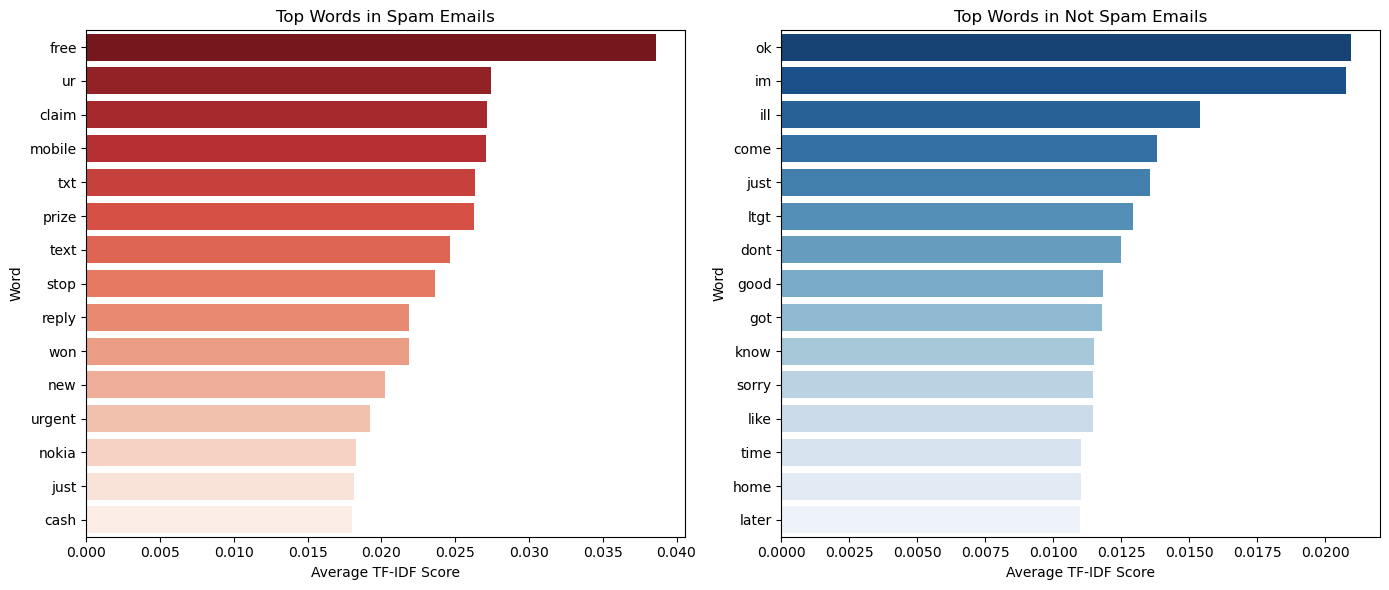

In [26]:
# Extra Cell: Top TF-IDF words per class (Spam vs Not Spam)

# Vectorize Spam emails
spam_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
spam_tfidf = spam_vectorizer.fit_transform(spam_texts)
spam_features = spam_vectorizer.get_feature_names_out()
spam_scores = np.asarray(spam_tfidf.mean(axis=0)).ravel()
spam_df = pd.DataFrame({'word': spam_features, 'score': spam_scores}).sort_values(by='score', ascending=False).head(15)

# Vectorize Not Spam emails
notspam_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
notspam_tfidf = notspam_vectorizer.fit_transform(notspam_texts)
notspam_features = notspam_vectorizer.get_feature_names_out()
notspam_scores = np.asarray(notspam_tfidf.mean(axis=0)).ravel()
notspam_df = pd.DataFrame({'word': notspam_features, 'score': notspam_scores}).sort_values(by='score', ascending=False).head(15)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x='score', y='word', hue='word', data=spam_df, palette="Reds_r", legend=False, ax=axes[0])
axes[0].set_title("Top Words in Spam Emails")
axes[0].set_xlabel("Average TF-IDF Score")
axes[0].set_ylabel("Word")

sns.barplot(x='score', y='word', hue='word', data=notspam_df, palette="Blues_r", legend=False, ax=axes[1])
axes[1].set_title("Top Words in Not Spam Emails")
axes[1].set_xlabel("Average TF-IDF Score")
axes[1].set_ylabel("Word")

plt.tight_layout()
plt.show()


In [29]:
# Cell 7: Train different models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": LinearSVC(dual="auto")  # fixed warning
}
results = {}
for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")


Naive Bayes Accuracy: 0.9695
Logistic Regression Accuracy: 0.9552
Random Forest Accuracy: 0.9722
SVM Accuracy: 0.9803


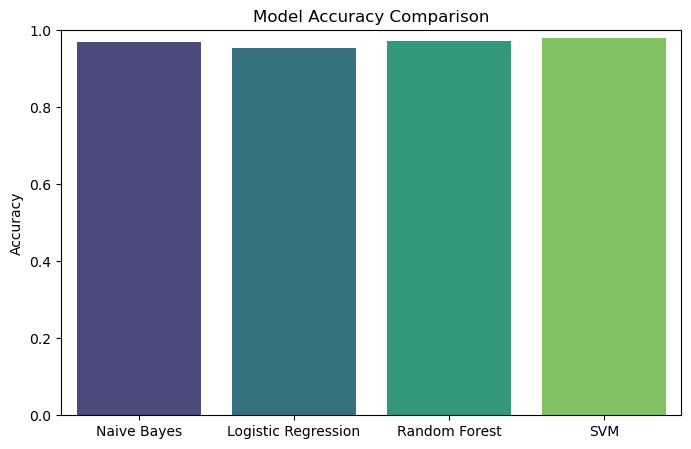

In [32]:
# Cell 8: Compare model accuracies
plt.figure(figsize=(8,5))
sns.barplot(
    x=list(results.keys()), 
    y=list(results.values()), 
    hue=list(results.keys()),  # future-proof
    palette="viridis", 
    legend=False
)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


In [33]:
# Cell 9: Hyperparameter tuning for Naive Bayes
param_grid = {"alpha": [0.1, 0.5, 1.0]}
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_tfidf, y_train)

print("Best Parameters for Naive Bayes:", grid.best_params_)
print("Best Cross-Validation Accuracy:", grid.best_score_)


Best Parameters for Naive Bayes: {'alpha': 0.1}
Best Cross-Validation Accuracy: 0.9798055291328833


Final Model Accuracy: 0.9829596412556054

Classification Report:
               precision    recall  f1-score   support

    Not Spam       0.98      1.00      0.99       965
        Spam       0.98      0.89      0.93       150

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115



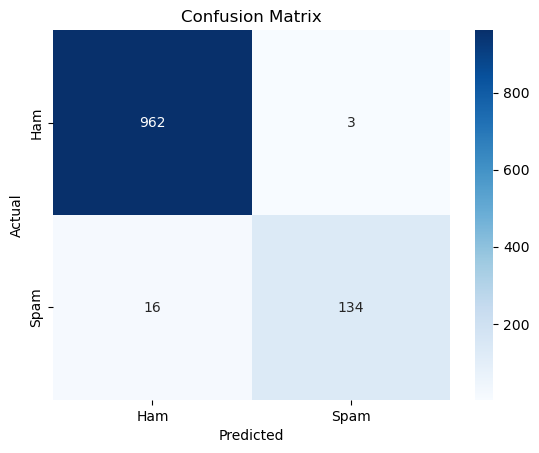

In [34]:
# Cell 10: Pick best model (Naive Bayes with best alpha here)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_tfidf)

print("Final Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Cell 11: Save the trained model & vectorizer
joblib.dump(best_model, "spam_classifier_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

# Load and test again
loaded_model = joblib.load("spam_classifier_model.pkl")
loaded_vectorizer = joblib.load("tfidf_vectorizer.pkl")

sample_email = ["Urgent! Your account will be suspended if you don’t pay now"]
sample_tfidf = loaded_vectorizer.transform(sample_email)
print("Prediction:", "Spam" if loaded_model.predict(sample_tfidf)[0]==1 else "Not Spam")


In [ ]:
with open("app.py", "w") as f:
    f.write('''import streamlit as st
import joblib

# Load model and vectorizer
model = joblib.load("spam_classifier_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Streamlit app
st.title("📧 Email Spam Classifier")
st.write("Enter an email below and find out if it's **Spam** or **Not Spam**.")

# User input
user_input = st.text_area("✍️ Type your email here:")

if st.button("Predict"):
    if user_input.strip() == "":
        st.warning("⚠️ Please enter some text before predicting.")
    else:
        # Transform input
        input_tfidf = vectorizer.transform([user_input])
        prediction = model.predict(input_tfidf)[0]

        # Show result
        if prediction == "spam":
            st.error("🚨 This email is **SPAM**!")
        else:
            st.success("✅ This email is **NOT SPAM**.")
''')


In [ ]:
!streamlit run app.py


In [ ]:
print("hello")


